# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

## Import Resources

In [1]:
import warnings
warnings.filterwarnings('ignore')

import time
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [2]:
import logging
import time
import json
from tensorflow.keras.preprocessing.image import ImageDataGenerator

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')

Using:
	• TensorFlow version: 2.9.1
	• tf.keras version: 2.9.0
	• GPU device not found. Running on CPU


## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [3]:
#Load the dataset with TensorFlow Datasets.
dataset, dataset_info = tfds.load('oxford_flowers102', as_supervised = True, with_info = True)

In [4]:
training_set, validation_set, test_set = dataset['train'],dataset['validation'], dataset['test']

## Explore the Dataset

In [5]:
#Get the number of examples in each set from the dataset info.

split_names = ['train', 'test', 'validation']
for i in split_names:
    print('The split {} has {} records'.format(i, dataset_info.splits[i].num_examples))
    
total_num_examples = dataset_info.splits['train'].num_examples

The split train has 1020 records
The split test has 6149 records
The split validation has 1020 records


In [6]:
# Get the number of classes in the dataset from the dataset info.
num_classes = dataset_info.features['label'].num_classes
print("Number of Classes is: ", num_classes)

Number of Classes is:  102


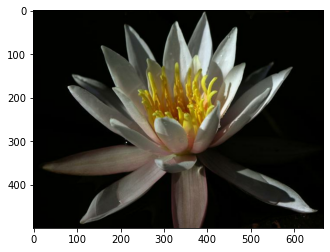

The shape of this image is: (500, 667, 3)
The label of this image is: 72


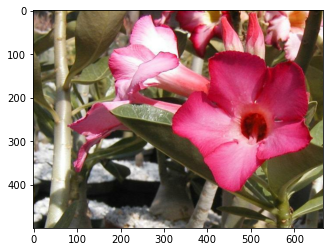

The shape of this image is: (500, 666, 3)
The label of this image is: 84


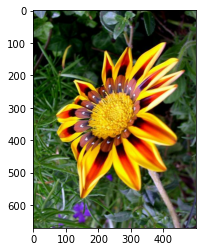

The shape of this image is: (670, 500, 3)
The label of this image is: 70


In [7]:
# Print the shape and corresponding label of 3 images in the training set.
# image, label = next(iter(training_set.take(1))) for one image to test.

for image, label in training_set.take(3):
    image = image.numpy()
    label = label.numpy()

    plt.imshow(image)
    plt.show()

    print('The shape of this image is:', image.shape)
    print('The label of this image is:', label)

### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [8]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

Text(0.5, 1.0, 'water lily')

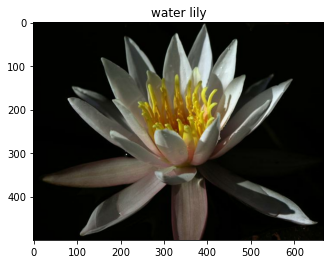

In [9]:
for image, label in training_set.take(1):
    image = image.numpy()
    label = label.numpy()

plt.imshow(image)
plt.title(class_names[str(label + 1)])

## Create Pipeline

In [10]:
# Create a pipeline for each set.

batch_size = 32
image_size = 224
train_split = 60

num_training_examples = (total_num_examples * train_split) // 100
print(num_training_examples)

612


In [11]:
def format_image(image, label):
    image = tf.cast(image, tf.float32)  # 
    image = tf.image.resize(image, (image_size, image_size))
    image /= 255
    return image, label


training_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(batch_size).prefetch(1)
validation_batches = validation_set.map(format_image).batch(batch_size).prefetch(1)
testing_batches = test_set.map(format_image).batch(batch_size).prefetch(1)

# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

Things we'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 


When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

In [12]:
# Build and train your network.
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/3" 

feature_extractor = hub.KerasLayer(URL, input_shape=(image_size, image_size,3))
feature_extractor.trainable = False

In [13]:
model = tf.keras.Sequential([feature_extractor,
        tf.keras.layers.Dense(num_classes, activation = 'softmax')])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


In [14]:
print('Is there a GPU Available:', tf.test.is_gpu_available())

Is there a GPU Available: False


In [15]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

EPOCHS = 5

history = model.fit(training_batches,
                        epochs=EPOCHS,
                    validation_data=validation_batches)


Epoch 1/5
32/32 [==============================] - 87s 2s/step - loss: 4.2445 - accuracy: 0.1284 - val_loss: 3.0546 - val_accuracy: 0.4088
Epoch 2/5
32/32 [==============================] - 74s 2s/step - loss: 2.0652 - accuracy: 0.6853 - val_loss: 1.9872 - val_accuracy: 0.6471
Epoch 3/5
32/32 [==============================] - 76s 2s/step - loss: 1.0985 - accuracy: 0.8971 - val_loss: 1.5243 - val_accuracy: 0.7353
Epoch 4/5
32/32 [==============================] - 77s 2s/step - loss: 0.6719 - accuracy: 0.9529 - val_loss: 1.2887 - val_accuracy: 0.7588
Epoch 5/5
32/32 [==============================] - 81s 3s/step - loss: 0.4521 - accuracy: 0.9804 - val_loss: 1.1523 - val_accuracy: 0.7824


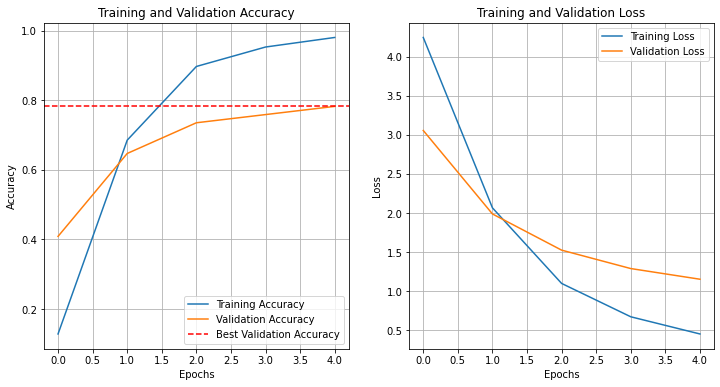

In [16]:
# Plot the loss and accuracy values achieved during training for the training and validation set.

training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(epochs_range, training_accuracy, label='Training Accuracy')
axes[0].plot(epochs_range, validation_accuracy, label='Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Training and Validation Accuracy')
axes[0].axhline(y=max(validation_accuracy), color='r', linestyle='--', label='Best Validation Accuracy')
axes[0].legend(loc='lower right')
axes[0].grid(True)

axes[1].plot(epochs_range, training_loss, label='Training Loss')
axes[1].plot(epochs_range, validation_loss, label='Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_title('Training and Validation Loss')
axes[1].legend(loc='upper right')
axes[1].grid(True)

#plt.savefig('training_plots.png')
plt.show()

## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [17]:
# Print the loss and accuracy values achieved on the entire test set.

loss, accuracy = model.evaluate(testing_batches)

print('\nLoss on the TEST Set: {:,.3f}'.format(loss))
print('Accuracy on the TEST Set: {:.3%}'.format(accuracy))

193/193 [==============================] - 220s 1s/step - loss: 1.2847 - accuracy: 0.7401

Loss on the TEST Set: 1.285
Accuracy on the TEST Set: 74.012%


## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [18]:
# Save your trained model as a Keras model.

timestamp = time.time()
saved_model_path = './{}.h5'.format(int(timestamp))

model.save(saved_model_path)

## Load the Keras Model

Load the Keras model you saved above.

In [19]:
# Load the Keras model

loaded_model = tf.keras.models.load_model(saved_model_path, custom_objects={'KerasLayer':hub.KerasLayer})
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [20]:
# Create the process_image function
def process_image(numpy_image):
    processed_image = tf.convert_to_tensor(numpy_image, dtype=tf.float32)
    processed_image = tf.image.resize(processed_image, (image_size, image_size))
    processed_image /= 255
    return processed_image.numpy()

To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

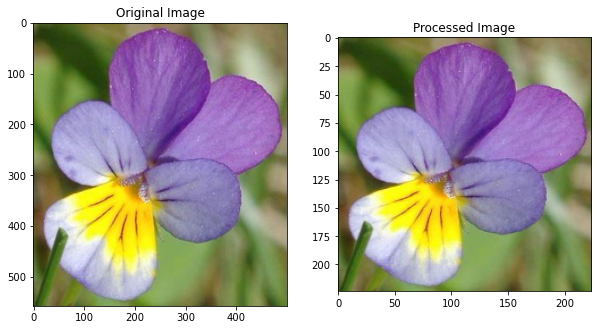

In [21]:
from PIL import Image

image_path = './test_images/wild_pansy.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')

ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')

fig.subplots_adjust(wspace=0.2)
#plt.savefig('Processed Image.png')
plt.show()

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [22]:
def predict(image_path, model, top_k):
    if top_k < 1:
        top_k = 1
    image = Image.open(image_path)
    image = np.asarray(image)
    image = process_image(image)
    expanded_image = np.expand_dims(image, axis=0)
    probes = loaded_model.predict(expanded_image)
    top_k_values, top_k_indices = tf.nn.top_k(probes, k=top_k)
    
    top_k_values = top_k_values.numpy()
    top_k_indices = top_k_indices.numpy()
    
    
    return top_k_values, top_k_indices, image

# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

1/1 [==============================] - 0s 136ms/step


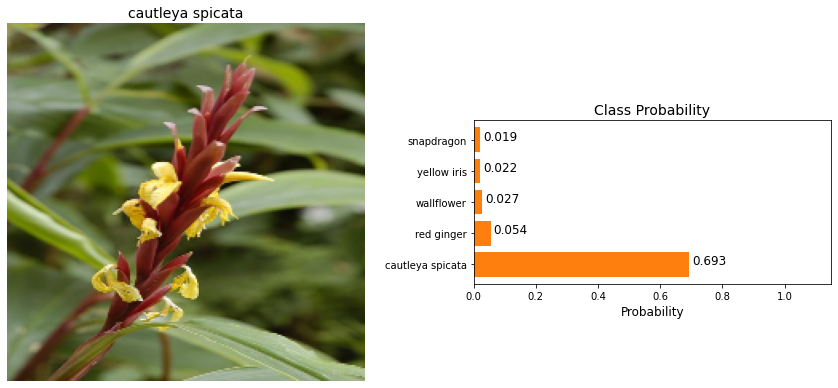

1/1 [==============================] - 0s 122ms/step


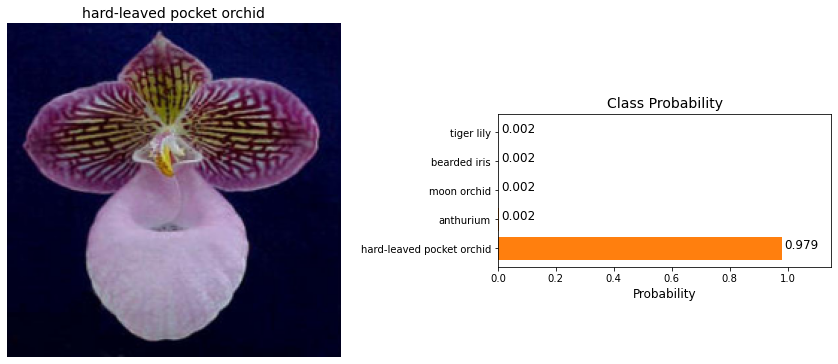

1/1 [==============================] - 0s 143ms/step


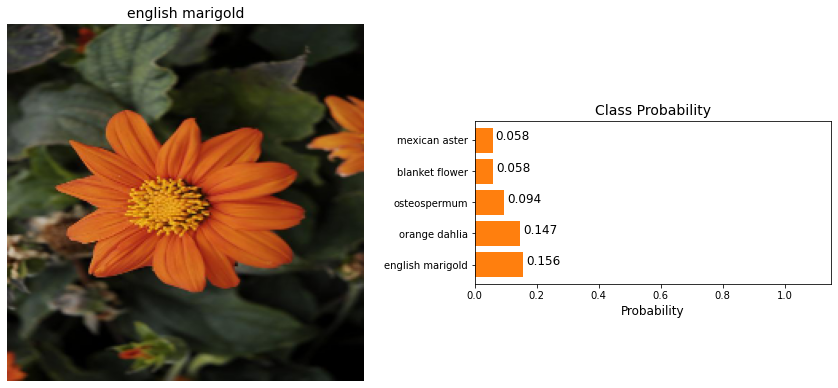

1/1 [==============================] - 0s 120ms/step


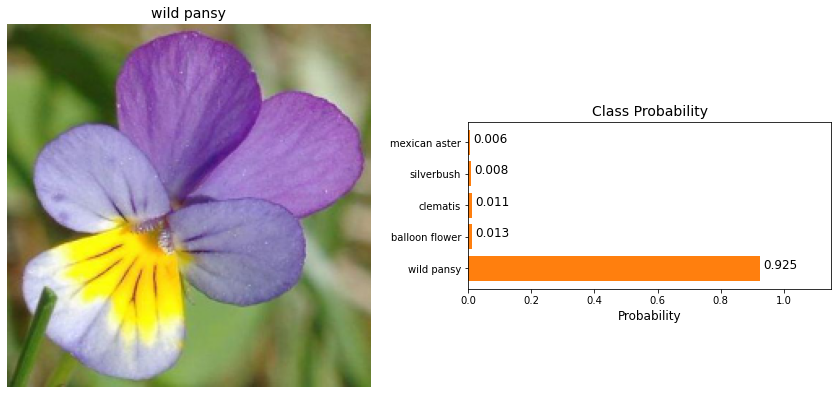

In [24]:
images = ['cautleya_spicata.jpg', 'hard-leaved_pocket_orchid.jpg', 'orange_dahlia.jpg', 'wild_pansy.jpg']

for img in images:
    url = './test_images/{}'.format(img)
    top_k_values, top_k_indices, image = predict(url, loaded_model, 5)
    
    flower_classes = []
    for idx in top_k_indices[0]:
        flower_classes.append(class_names[str(idx+1)])
        
    fig, (ax1, ax2) = plt.subplots(figsize=(12,10), ncols=2)
    
    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title(flower_classes[0], fontsize=14)
    
    ax2.barh(np.arange(5), top_k_values[0], label='Class Probability', color='#FF7F0E')
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(5))
    
    ax2.set_yticklabels(flower_classes, size='medium');
    ax2.set_title('Class Probability',fontsize=14)
    ax2.set_xlabel('Probability',fontsize=12)
    ax2.set_xlim(0, 1.15)
    for i, v in enumerate(top_k_values[0]):
        ax2.text(v + 0.01, i, str(round(v,3)), color='#000000', fontsize=12)
    plt.tight_layout(pad=2.0)

    plt.show()